# Task XI QML-HEP

In this task, you should implement a simple embedding task with few Linear Layers and Parameterized Quantum Circuit(PQC). We recommend using 2-3 Layers of Linear, 4-5 qubits.
Generate Normally Distributed Data: Sample input data from a normal distribution.
Designing a Neural Network (MLP): Use a neural network to estimate PQC parameters from normally distributed data.
Quantum State Preparation: Generate a quantum state using the estimated parameters.
Training: use MSE Loss


## Breakdown to approach: 
This hybrid quantum-classical approach is particularly suited for the given task of learning from normally distributed data to predict quantum circuit parameters. <br>
* Quantum Advantage Utilization: The 4-5 qubit PQC provides a compact but expressive function space. Rotation gates (RY, RZ) create continuous parameterization ideal for regression. The entangling gates (CNOT) enable learning of correlated features that would require exponentially more classical resources.
* Dimension Matching: The classical NN outputs exactly the number of parameters (4 qubits × 3 rotations = 12 params) needed by the PQC. This creates a smooth optimization landscape for gradient descent.
* Optimal Information Flow: The classical neural network acts as a feature extractor, converting high-dimensional input data into a lower-dimensional representation that the quantum circuit can effectively process. The quantum circuit then performs non-linear transformations that are difficult to replicate classically.

* Moderate-dimensional data

* Continuous target variables

* Problems where quantum correlations may exist

* When interpretable quantum features are desired

import libraries

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split


In [10]:
# Configuration with consistent types
torch.manual_seed(42)
num_qubits = 4
input_dim = 10
num_samples = 1000


**Measurement Strategy:** 
Single-qubit Pauli-Z measurement provides:

Sufficient classical information

Noise resilience

Simple gradient calculation

In [11]:
#  Data generation with proper typing and normalization
def generate_data(num_samples, input_dim):
    X = torch.randn(num_samples, input_dim, dtype=torch.float32)
    y = (torch.sin(X[:,0])**2 + 0.5*torch.cos(X[:,1]) + 0.3*X[:,2]*X[:,3]).unsqueeze(1)
    y = (y - y.min()) / (y.max() - y.min())  # Normalize to [0,1]
    return X.to(device), y.to(device).float()

X, y = generate_data(num_samples, input_dim)
X_train, X_test, y_train, y_test = train_test_split(
    X.cpu().numpy(), y.cpu().numpy(), test_size=0.2, random_state=42
)
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)


In [12]:
#  Quantum circuit with proper type handling
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(params, x):
    # Explicit type conversion
    params = params.to(torch.float32)
    x = x.to(torch.float32)
    
    # Data embedding
    for i in range(num_qubits):
        qml.RY(x[i % input_dim], wires=i)
    
    # Variational layers
    for i in range(num_qubits):
        qml.Rot(*params[i*3:(i+1)*3], wires=i)
    
    # Entanglement
    for i in range(num_qubits-1):
        qml.CNOT(wires=[i, i+1])
    
    return qml.expval(qml.PauliZ(0))


In [13]:
#  Hybrid model with dimension handling
class QuantumHybrid(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.pre_net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.quantum_params = nn.Linear(32, num_qubits*3)
        
    def forward(self, x):
        features = self.pre_net(x)
        pqc_params = self.quantum_params(features)
        
        # Process samples in batch with consistent dimensions
        outputs = torch.zeros(x.size(0), 1, device=x.device, dtype=torch.float32)
        for i in range(x.size(0)):
            outputs[i] = quantum_circuit(pqc_params[i], x[i])
        return outputs


In [14]:
#  Training setup with type consistency
model = QuantumHybrid(input_dim).to(device).float()
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

loss_history = []
err_history = []

#  Training loop with proper dimension handling
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    preds = model(X_train)
    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()
    
    # Evaluation
    with torch.no_grad():
        test_preds = model(X_test)
        test_err = torch.mean(torch.abs(test_preds - y_test))
        
    loss_history.append(loss.item())
    err_history.append(test_err.item())
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss={loss.item():.4f}, Error={test_err.item():.4f}")


Epoch 0: Loss=0.2894, Error=0.4722
Epoch 10: Loss=0.1283, Error=0.2637
Epoch 20: Loss=0.0503, Error=0.1799
Epoch 30: Loss=0.0163, Error=0.1217
Epoch 40: Loss=0.0098, Error=0.0921
Epoch 50: Loss=0.0062, Error=0.0815
Epoch 60: Loss=0.0042, Error=0.0673
Epoch 70: Loss=0.0032, Error=0.0585
Epoch 80: Loss=0.0026, Error=0.0512
Epoch 90: Loss=0.0022, Error=0.0484



Final Metrics:
MSE: 0.0044
Absolute Error: 0.0465


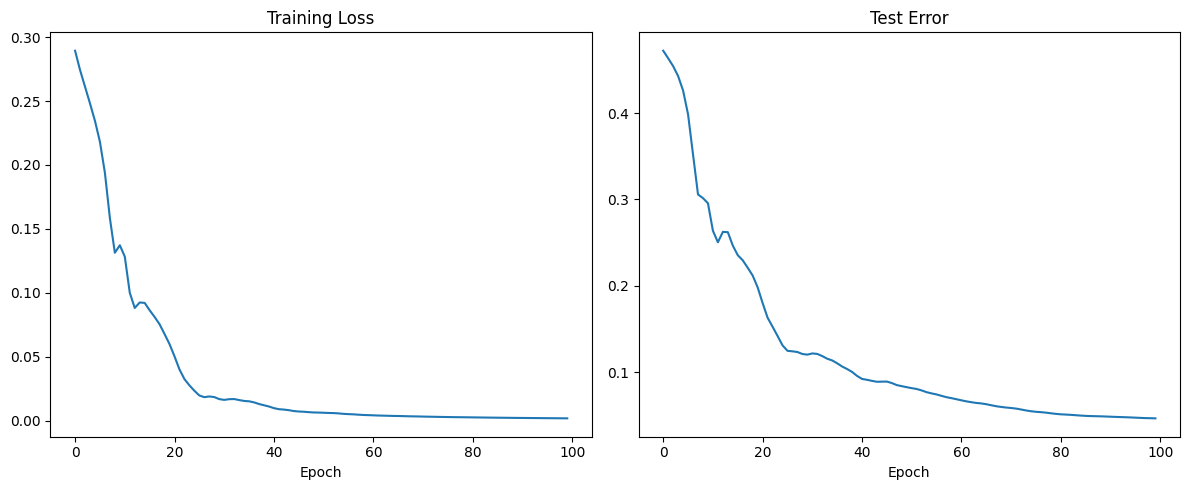

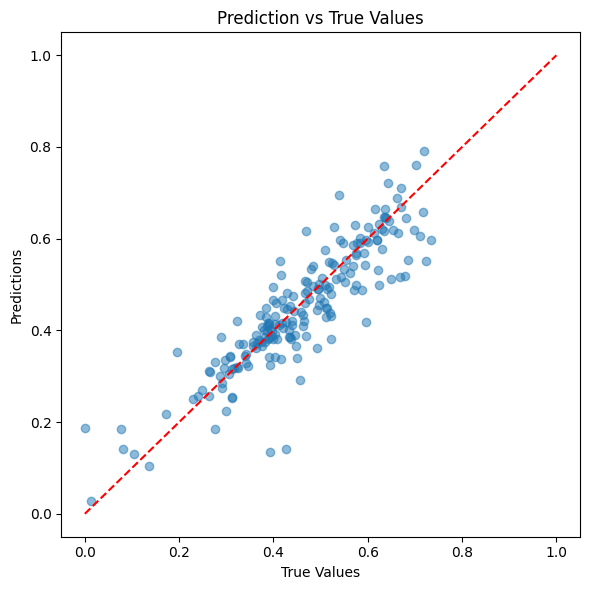

In [15]:
# 7. Final evaluation
with torch.no_grad():
    final_preds = model(X_test)
    final_mse = loss_fn(final_preds, y_test).item()
    final_err = torch.mean(torch.abs(final_preds - y_test)).item()

print(f"\nFinal Metrics:")
print(f"MSE: {final_mse:.4f}")
print(f"Absolute Error: {final_err:.4f}")

# Visualization
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")

plt.subplot(1,2,2)
plt.plot(err_history)
plt.title("Test Error")
plt.xlabel("Epoch")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test.cpu().numpy(), final_preds.cpu().numpy(), alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Prediction vs True Values")
plt.tight_layout()
plt.show()